Note:
* I referenced the L4 Notebook for the code under Model and Model Testing.
* I also referenced W3Schools' Machine Learning - Confusion Matrix article/guide (https://www.w3schools.com/python/python_ml_confusion_matrix.asp) to create the confusion matrix under the Model Testing section.

### **Data Preprocessing**

In [ ]:
!pip install transformers

In [ ]:
import os
import kagglehub

# Download latest version
path = kagglehub.dataset_download("emineyetm/fake-news-detection-datasets")

print("Path to dataset files:", path)

print(os.listdir(path))
print(os.listdir(os.path.join(path, 'News _dataset')))

100%|██████████| 41.0M/41.0M [00:00<00:00, 62.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/emineyetm/fake-news-detection-datasets/versions/1
['News _dataset']
['True.csv', 'Fake.csv']


In [ ]:
import pandas as pd
truedf = pd.read_csv(os.path.join(path, 'News _dataset/True.csv'))
truedf['label'] = 1
truedf.sample(5)[['title', 'label']]

,title,label
5487,Few good options in Trump arsenal to counter d...,1
13422,EU and Britain agree settlement post Brexit: s...,1
575,Myanmar operation against Rohingya has 'hallma...,1
9836,Sen. Warren demands answers from U.S. regulato...,1
3492,U.S. says open to talks on protected status fo...,1


In [ ]:
fakedf = pd.read_csv(os.path.join(path, 'News _dataset/Fake.csv'))
fakedf['label'] = 0
fakedf.sample(5)[['title', 'label']]

,title,label
4535,"Facing Tough Re-Election, Sheriff Joe Says He...",0
15343,HILLARY CLINTON CRASHING IN POLLS: Moves To Ob...,0
3550,Joe Biden Makes BIG News About 2020 Election,0
13063,OBAMA NOMINATES FIRST MUSLIM FOR FEDERAL BENCH...,0
20698,WHY MAN WHO RAPED AND MURDERED HIS TEACHER Thi...,0


In [ ]:
df = pd.concat([truedf, fakedf])
df = df.sample(frac=1, random_state=1)
df[['title', 'label']]

,title,label
4528,EPA chief says Paris climate agreement 'bad de...,1
10310,BREAKING NEWS: President Trump Announces Major...,0
10937,Trump says New Hampshire win not necessary to ...,1
13470,Kremlin: U.S. sanctions aimed at turning busin...,1
19397,MUST WATCH: Kellyanne Conway PUNCHES BACK Afte...,0
...,...,...
22306,THIS YEAR: Let’s Make Christmas Great Again…,0
11094,DEMOCRATS SELL Promo T-Shirt: “Democrats give ...,0
5192,White House aides told to preserve materials i...,1
12172,'Congratulations': EU moves to Brexit phase tw...,1


In [ ]:
titles = df.title.values
labels = df.label.values

### Tokenization

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
import torch

input_ids = []
attention_masks = []

for title in titles:
  encoded_dict = tokenizer.encode_plus(
      text = title,
      add_special_tokens = True,
      max_length = 30,
      truncation = True,
      padding = 'max_length',
      return_attention_mask = True,
      return_tensors = 'pt'
  )
  input_ids.append(encoded_dict['input_ids'])
  attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

<ipython-input-35-232fe5e8a534>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


In [ ]:
print('Original: ', titles[0])
print('Token IDs: ', input_ids[0])
print('Attention Mask: ', attention_masks[0])

Original:  EPA chief says Paris climate agreement 'bad deal' for U.S.
Token IDs:  tensor([  101, 19044,  2708,  2758,  3000,  4785,  3820,  1005,  2919,  3066,
         1005,  2005,  1057,  1012,  1055,  1012,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
Attention Mask:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0])


### **Model**

### Training, Validation, and Test Split

In [ ]:
from torch.utils.data import TensorDataset, random_split
dataset = TensorDataset(input_ids, attention_masks, labels)

print(len(dataset)) # 44898

train_size = 8000
val_size = 1000
test_size = 1000
# not using the entire dataset due to computational limitations
remaining_size = len(dataset) - train_size - val_size - test_size

train_dataset, val_dataset, test_dataset, remaining_dataset = random_split(dataset, [train_size, val_size, test_size, remaining_size])

44898


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_dataloader = DataLoader(
    train_dataset,
    sampler = RandomSampler(train_dataset),
    batch_size = batch_size
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler = SequentialSampler(val_dataset),
    batch_size = batch_size
)

test_dataloader = DataLoader(
    test_dataset,
    sampler = SequentialSampler(test_dataset),
    batch_size = batch_size
)

### Training

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      output_hidden_states = False,
                                                      output_attentions = False)

model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
optimizer = AdamW(model.parameters(), lr = 2e-5)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 2

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

def accuracy(predictions, labels):
  predicted_classes = np.argmax(predictions, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(predicted_classes == labels_flat) / len(labels_flat)

In [ ]:
import random

device = torch.device('cuda')

seed_val = 1
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)

training_stats = []

print("Training")

for epoch_i in range(0, epochs):
  print("")
  print('Epoch',epoch_i+1)
  total_train_loss = 0
  model.train()
  for step, batch in enumerate(train_dataloader):
    if step % 40 == 0 and not step == 0:
      print('  Batch', step,' of ', len(train_dataloader))

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    model.zero_grad()
    result = model(b_input_ids,
                   token_type_ids = None,
                   attention_mask = b_input_mask,
                   labels = b_labels,
                   return_dict=True)
    loss = result.loss
    logits = result.logits
    total_train_loss += loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()

  avg_train_loss = total_train_loss / len(train_dataloader)
  print("Average training loss: ", avg_train_loss)

  print("")
  print("Validation")
  print("")

  model.eval()
  total_eval_accuracy = 0
  total_eval_loss = 0
  nb_eval_steps = 0

  for batch in validation_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():
      result = model(b_input_ids,
                     token_type_ids = None,
                     attention_mask = b_input_mask,
                     labels = b_labels,
                     return_dict=True)

    loss = result.loss
    logits = result.logits
    total_eval_loss += loss.item()
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    total_eval_accuracy += accuracy(logits, label_ids)

  avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
  print("  Accuracy: ", avg_val_accuracy)
  avg_val_loss = total_eval_loss / len(validation_dataloader)
  print("  Average validation loss: ", avg_val_loss)

  training_stats.append(
      {
          'Epoch': epoch_i + 1,
          'Training Loss': avg_train_loss,
          'Valid. Loss': avg_val_loss,
          'Valid. Accur.': avg_val_accuracy
      }
  )

Training

Epoch 1
  Batch 40  of  250
  Batch 80  of  250
  Batch 120  of  250
  Batch 160  of  250
  Batch 200  of  250
  Batch 240  of  250
Average training loss:  0.17668399172555654

Validation

  Accuracy:  0.9716796875
  Average validation loss:  0.09780125137331197

Epoch 2
  Batch 40  of  250
  Batch 80  of  250
  Batch 120  of  250
  Batch 160  of  250
  Batch 200  of  250
  Batch 240  of  250
Average training loss:  0.05153773759258911

Validation

  Accuracy:  0.9765625
  Average validation loss:  0.08993060579450685


### Training Summary

In [ ]:
pd.set_option('display.precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('Epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.
Epoch,,,
1,0.18,0.10,0.97
2,0.05,0.09,0.98


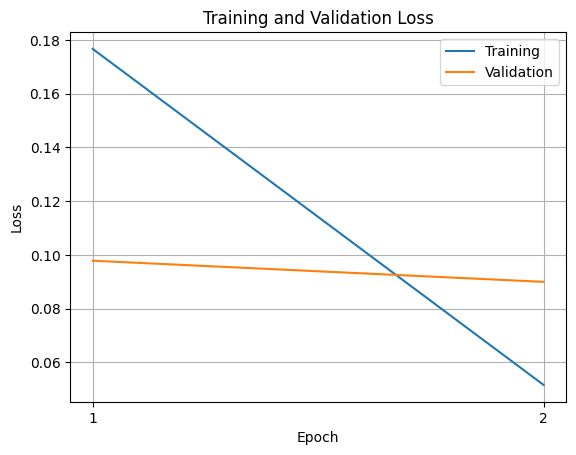

In [ ]:
import matplotlib.pyplot as plt

plt.grid()
plt.plot(df_stats['Training Loss'], label='Training')
plt.plot(df_stats['Valid. Loss'], label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks([1, 2])
plt.legend()
plt.show()

### **Model Testing**

Model Testing



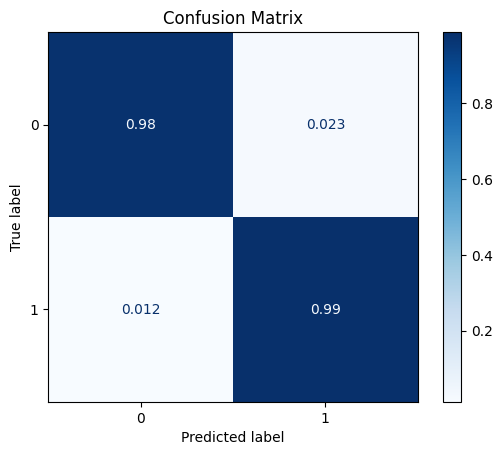

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("Model Testing")
print("")

model.eval()
predictions, true_labels = [], []

for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
    result = model(b_input_ids,
                   token_type_ids=None,
                   attention_mask=b_input_mask,
                   return_dict=True)

  logits = result.logits
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)

predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)


# Note: I referenced W3Schools' Machine Learning - Confusion Matrix article/guide
# (https://www.w3schools.com/python/python_ml_confusion_matrix.asp) for the following code:
predicted_classes = np.argmax(predictions, axis=1)
cm = confusion_matrix(true_labels, predicted_classes, normalize ='true')
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm,
                                    display_labels = [0,1])

cm_display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()